<a href="https://colab.research.google.com/github/Nerikoutchala/Nerikoutchala/blob/main/Generalisable_cardiac_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Step 1. Download data

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
gdown 4.6.4 at /usr/local/lib/python3.9/dist-packages


In [3]:
# Download the dataset
!gdown "1UojNr21N02bRXuOi2vOBlQ9z0X7OSJ0p"

Downloading...
From: https://drive.google.com/uc?id=1UojNr21N02bRXuOi2vOBlQ9z0X7OSJ0p
To: /content/mnms_bigdataschool.tar.xz
100% 121M/121M [00:01<00:00, 76.7MB/s]


In [4]:
import tarfile
# Unzip the '.tar.xz' file to the current directory
datafile = tarfile.open('mnms_bigdataschool.tar.xz')
datafile.extractall(path='./data')
datafile.close()

In [5]:
# Step 2. Load and visualize data
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import cv2

In [6]:
# cargando un ejemplo
nii_file = nib.load('./data/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED.nii.gz')
image = nii_file.get_fdata()
type(image), image.shape

(numpy.ndarray, (216, 256, 13))

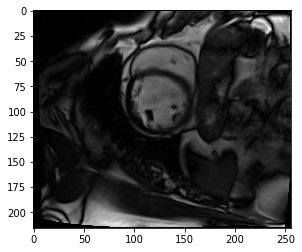

In [7]:
# Let's plot the 5th component from the last axis
# (that is, the array of shape (216,256) in fifth position in the last axis)
plt.imshow(image[...,5], cmap='gray')

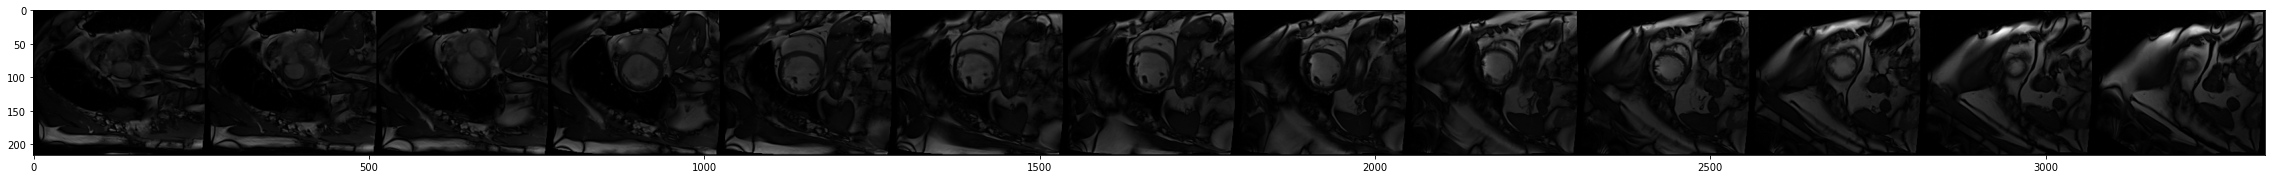

In [8]:
# Let's plot now all the components separately (note that the last component is the heart axis)
plt.figure(figsize=(40,16))
plt.imshow(
    np.hstack([*np.moveaxis(image,2,0)]), cmap='gray')
plt.show()

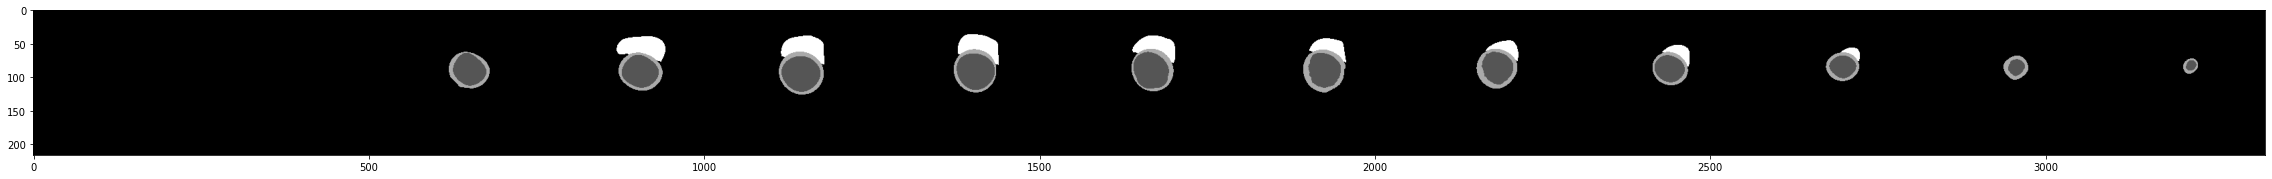

In [9]:
# delineacion
nii_file = nib.load('./data/mnms_nifti/training/A0S9V9/A0S9V9_sa_ED_gt.nii.gz')
delin = nii_file.get_fdata()
# Let's plot all the components separately as well
plt.figure(figsize=(40,16))
plt.imshow(
    np.hstack([*np.moveaxis(delin,2,0)]), cmap='gray')
plt.show()

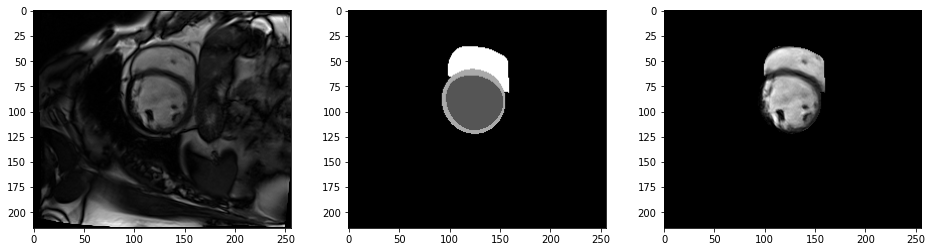

In [10]:
# Combinamos los dos
# We can crop the delineated part, for example:
z = 5 # Choose the 5th component again, as an example

f, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].imshow(image[...,z], cmap='gray')
axs[1].imshow(delin[...,z], cmap='gray')
axs[2].imshow(image[...,z] * np.clip(delin[...,z], 0, 1), cmap='gray')

plt.show()

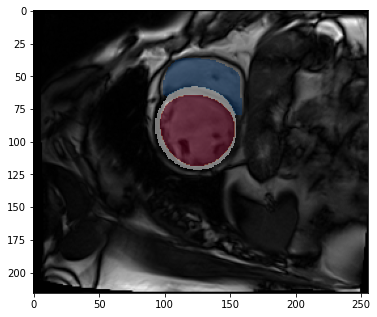

In [11]:
# visualizando la delineacion sobre la imagen:
z = 5

plt.figure(figsize=(6,6))
plt.imshow(image[...,z], cmap='gray')
masked = np.ma.masked_where((delin[...,z] == 0), delin[...,z])
plt.imshow(masked, cmap='RdBu', alpha=0.5)

plt.show()

**Images in PNG format**

In order to work more easily, we converted the files to PNG format from Nifti. You can check that they can be visualized in a similar manner.

Note that image intensities are now in the range [0, 255] while the mask values are integers {0,1,2,3}.

We rescale them in the plot for better contrast. You can try to plot without rescaling to see what happens.

In [12]:
def rescale(im, _min=0, _max=1):
    '''
    Rescale the input image intensities to a given range [_min, _max]
    '''
    assert _max > 0, 'Max value must be greater than 0.'
    assert type(im) == np.ndarray, 'Pass image as a numpy array.'

    return _max * (im - im.min() + _min) / (im.max() - im.min())

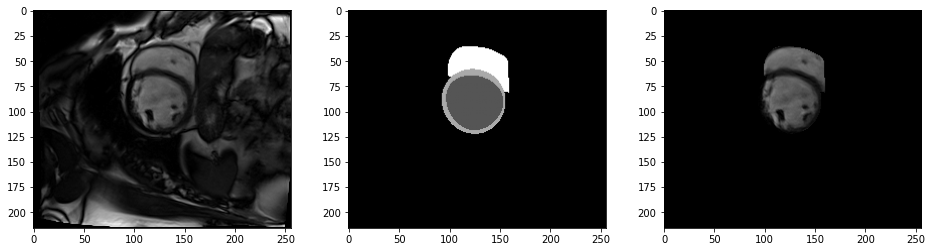

In [13]:
image = cv2.imread('./data/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z05.png')
delin = cv2.imread('./data/mnms_png/training/A0S9V9/A0S9V9_sa_ED_z05_gt.png')
image = rescale(image)
f, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rescale(delin), cmap='gray')
axs[2].imshow(image * np.clip(delin, 0, 1), cmap='gray')

plt.show()

**Step 3. Build your model**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Estructura del Modelo**

In [15]:
# In pytorch, the models have the following class structure, with a initialization or constructor function and a forward that is called everytime the model is called:
class UNetSample(nn.Module):
    def __init__(self):
        'Define the LAYERS of network'
        super().__init__()
        self.layer1 = nn.Identity()
        self.layer2 = nn.Identity()
        
        self.outlayer = nn.Identity()

    def forward(self, input_image):
        'Specify how data is TRANSFORMED through the network'
        x1 = self.layer1(input_image)
        x2 = self.layer2(x1)
        logits = self.outlayer(x2)

        return logits

In [16]:
# We work with these models by instantiating them first
model = UNetSample()

In [17]:
# and calling them on input data (images). An image is passed as input and transformed to a new image (identity transformation for this case):
image = torch.ones((5,5))
model(image)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

**Let's build a real U-Net**

We need the building blocks first. So let's build them in a clean and modular way.

First, we need the basic building block, which is a composition of a convolutional operation, a normalization layer and an activation function (x2):

In [18]:
# Notice the use of dynamical variables for the output_channels to implement blocks with varying number of channels (64, 128, 256, 512).
class DoubleConv(nn.Module):
    '''
    |------|    |------|    |------|    |------|    |------|    |------|
    | Conv | => | [BN] | => | ReLU | => | Conv | => | [BN] | => | ReLU |
    |------|    |------|    |------|    |------|    |------|    |------|
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # One
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Two
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
     

In [19]:
# And then we can compose it with the downsampling block

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # Use the previous block
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [20]:
# and the upsampling block

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Notice the two inputs:
        # - x1 (the data from the previous block, goes through the green arrow)
        # - x2 (the data from the equivalent layer of the encoding path, goes through the gray arrow)
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Fix size issues to match dimensions of x1 and x2 arrays
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate both arrays
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [21]:
# The last layer is simply a 1x1 convolution (light blue color in the figure above) so we create another class for it as well:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [22]:
# Now we can put the pieces together to create our first model

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoding leg
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # Decoding leg
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
     

In [23]:
model = UNet(1,3)

In [24]:
image = torch.ones((1,1,256,256))
output = model(image)
output.shape

torch.Size([1, 3, 256, 256])

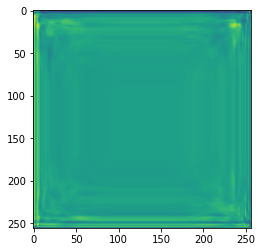

In [25]:
plt.imshow(output[0,0].detach().numpy())

**Step 4. Train your model**

Now we are ready to train a deep learning model. For the training we need to consider the selection of adequate data augmentation, one or a combination of several loss functions and an optimizer.

In [26]:
import glob
import torch
from skimage.transform import resize 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
     

In [27]:
# Loss function: For this run we'll use the Binary Cross-Entropy

loss_fn = nn.BCELoss()

**Optimizers**

The algorithm that updates the weights of the network based on the loss function.

There are plenty of algorithms and variations, but we will use the basic one: Stochastic Gradient Descent (SGD).

In [28]:
model = UNet(n_channels=1, n_classes=4)
# We need to provide the weights of the model we are training
optimizer = optim.SGD(model.parameters(), lr=1e-3)

**Data augmentation**

To implement the different data augmentation we'll use monai, a python-based framework for deep learning in healthcare imaging.

It has many functions that will save us time.

In [29]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00


In [30]:
from monai.data import Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Resized, RandRotated, \
    ScaleIntensityd, EnsureTyped, RandBiasFieldd, RandAdjustContrastd, \
    AsDiscreted, ToTensord, Rand2DElasticd

In monai, we specify the augmentation techniques as a list of transformations. We'll consider some of the augmentations listed above: bias field modification, contrast adjustment, elastic deformations and rotations.

In [31]:
k = ["img", "seg"]
num_classes = 4
spatial_size = (256, 256)

seg_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    RandBiasFieldd(keys=["img"], prob=0.5),
    RandAdjustContrastd(keys=["img"], prob=0.5),
    Rand2DElasticd(
        keys=k, prob=1, spacing=[20,20],
        magnitude_range=(1,2), mode=["bilinear", "nearest"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    RandRotated(
        keys=k, prob=0.5, range_x=15,
        mode=['bilinear', 'nearest']
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [32]:
image_filenames = list(sorted(glob.iglob('./data/mnms_png/training/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob('./data/mnms_png/training/*/*_sa_E?_z??_gt.png')))

transform = Compose(seg_transforms)
train_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

train_dset = Dataset(train_files_dict, transform=transform)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True)
     

In [33]:
def train(dataloader, model, loss_fn, optimizer, device='cuda'):
    size = len(dataloader.dataset)
    model.train()
    for bidx, batch in enumerate(dataloader):
        X, y = batch['img'], batch['seg']
        X, y = X.to(device).float(), y.to(device).float()

        # Compute prediction error
        pred = model(X)
        pred = F.softmax(pred, dim=1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if bidx % 100 == 0:
            loss, current = loss.item(), bidx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [34]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

model = UNet(1, num_classes).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dloader, model, loss_fn, optimizer, device)
print("Done!")
     

Device: cuda
Epoch 1
-------------------------------
loss: 0.483104  [    0/ 3284]
loss: 0.428612  [  400/ 3284]
loss: 0.336632  [  800/ 3284]
loss: 0.294660  [ 1200/ 3284]
loss: 0.242987  [ 1600/ 3284]
loss: 0.200529  [ 2000/ 3284]
loss: 0.215597  [ 2400/ 3284]
loss: 0.181362  [ 2800/ 3284]
loss: 0.140592  [ 3200/ 3284]
Epoch 2
-------------------------------
loss: 0.161104  [    0/ 3284]
loss: 0.151835  [  400/ 3284]
loss: 0.127281  [  800/ 3284]
loss: 0.133351  [ 1200/ 3284]
loss: 0.109070  [ 1600/ 3284]
loss: 0.103943  [ 2000/ 3284]
loss: 0.080383  [ 2400/ 3284]
loss: 0.102819  [ 2800/ 3284]
loss: 0.107529  [ 3200/ 3284]
Epoch 3
-------------------------------
loss: 0.120088  [    0/ 3284]
loss: 0.090559  [  400/ 3284]
loss: 0.076884  [  800/ 3284]
loss: 0.081927  [ 1200/ 3284]
loss: 0.095094  [ 1600/ 3284]
loss: 0.097350  [ 2000/ 3284]
loss: 0.066077  [ 2400/ 3284]
loss: 0.092309  [ 2800/ 3284]
loss: 0.088192  [ 3200/ 3284]
Epoch 4
-------------------------------
loss: 0.104332  [

we can save the model to disk, so that we can recover it whenever we want.

In [35]:
import os
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_3ep.pt')

Finally, we can check the predictions of the model on the testing (unseen) images.

In [36]:
test_transforms = [
    LoadImaged(keys=k),
    EnsureChannelFirstd(keys=k),
    ScaleIntensityd(keys=["img"]),
    ToTensord(keys=k),
    # Round mask values to closest integer
    AsDiscreted(keys=["seg"], rounding='torchrounding'),
    # Convert mask labels to num_classes image with 1s
    AsDiscreted(
        keys=["seg"], to_onehot=num_classes
    ),
    Resized(keys=k, spatial_size=spatial_size),
    EnsureTyped(keys=k),
]

In [37]:
image_filenames = list(sorted(glob.iglob('./data/mnms_png/testing/*/*_sa_E?_z??.png')))
mask_filenames  = list(sorted(glob.iglob('./data/mnms_png/testing/*/*_sa_E?_z??_gt.png')))

transform = Compose(test_transforms)
test_files_dict = [{"img": img, "seg": seg} for img, seg in zip(image_filenames, mask_filenames)]

test_dset = Dataset(test_files_dict, transform=transform)
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False)

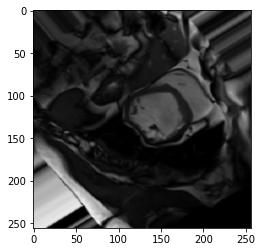

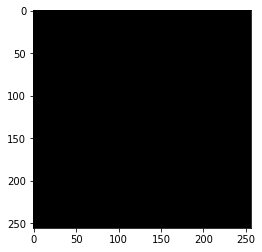

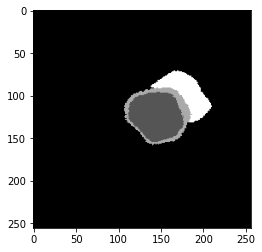

In [38]:
batch = train_dset.__getitem__(4)
img, gt = batch['img'], batch['seg']
model.eval()
pred = model(img.to(device).unsqueeze(0))
plt.imshow(img[0].detach(), cmap='gray'); plt.show()
out = F.softmax(pred, dim=1).argmax(dim=1).squeeze()
plt.imshow(out.detach().cpu(), cmap='gray'); plt.show()
gt.shape
gt = gt.argmax(dim=0)
plt.imshow((gt-gt.min())/(gt.max()-gt.min()), cmap='gray'); plt.show()
